In [ ]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [1]:
import PySimpleGUI as sg    
from pykat import finesse
from pykat.commands import * 
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math

sg.theme('Default1')

def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# pd interferometer finesseの結果 引数
# log

In [3]:
# PRFPMIように下のような関数作る

In [4]:
def generate_kat_FPMI(l_port_true, l_pd_true, dic_advanced_setting):

    ##############################
    ### get variables from GUI ###
    ##############################

    ### Extra Settings ###
    laser_power = dic_advanced_setting["laser_power"]#source laser power
    
    ### DoF ###
    #
    # (yuzu) pick up DoF (CARM / DARM / BS) from GUI
    # 
    dof = dic_advanced_setting["dof"]#CARM DARM BS
    
    ### sweep_power/sweep_demod_1/transferfunction_power/transferfunction_demod_2 ###
    type_of_pd_signal = dic_advanced_setting["type_of_pd_signal"]#(sweep_mode)
    ### xaxis/yaxis setting ###
    x_plotscale = dic_advanced_setting["x_plotscale"]#str
    xaxis_range_beg = dic_advanced_setting["xaxis_range_beg"]#str
    xaxis_range_end = dic_advanced_setting["xaxis_range_end"]#str
    y_plotscale = dic_advanced_setting["y_plotscale"]#str
    if x_plotscale=='linear':
        x_plotscale = 'lin'
    if y_plotscale=='linear':
        y_plotscale = 'lin'
    samplingnum = dic_advanced_setting["samplingnum"]

    ### pd1 advanced setting/pd2 advanced setting ###
    pd1_demod_phase = dic_advanced_setting["pd1_demod_phase"]#str
    pd1_demodfreq = dic_advanced_setting["pd1_demodfreq"]#str
    pd2_demod_phase = dic_advanced_setting["pd2_demod_phase"]#str
    pd2_mixer1_demodfreq = dic_advanced_setting["pd2_mixer1_demodfreq"]#str
    #
    # default demod_phase, demod_freque is Pd1's configuration
    #
    demod_phase = dic_advanced_setting["pd1_demod_phase"]#str
    demod_freq = dic_advanced_setting["pd1_demodfreq"]#str
    if(type_of_pd_signal=="transferfunction_demod_2"):
        demod_phase  = dic_advanced_setting["pd2_demod_phase"]#str
        demod_freq = dic_advanced_setting["pd2_mixer1_demodfreq"]#str
    #
    # demod_phase_I,demod_phase_Q must define after demod_phase is defined
    #
    demod_phase_I = str(0+float(demod_phase))#str
    demod_phase_Q = str(90+float(demod_phase))#str

    ######################
    ### INF components ###
    ######################
    #
    # Prepare common (fixed for KAGRA) setting for kat file 
    # 
    input_finesse = """
    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

    """ % (laser_power)

    ### PDs location ###
    pd0s_code = ""
    pd1s_code = ""
    pd2s_code = ""

    #
    # 選択したpdだけを追加する機能をあとでつけたいので、あえてif文を分けた
    #
    if type_of_pd_signal == "sweep_power" or type_of_pd_signal == "transferfunction_power":
        for port in l_port_true:
            input_finesse += """    
pd0 pd0_%s %s
                            """ % (port, port)

    elif type_of_pd_signal == "sweep_demod_1":
        for port in l_port_true:
            
            input_finesse += """
pd1 pd1_I1_%s $f1_SB %s %s
pd1 pd1_Q1_%s $f1_SB %s %s
pd1 pd1_I2_%s $f2_SB %s %s
pd1 pd1_Q2_%s $f2_SB %s %s
pd1 pd1_IX_%s %s %s %s
pd1 pd1_QX_%s %s %s %s
                    """% (port, demod_phase_I, port,
                        port, demod_phase_Q, port,
                        port, demod_phase_I, port,
                        port, demod_phase_Q, port,
                        port, demod_freq, demod_phase_I, port,
                        port, demod_freq, demod_phase_Q, port
                        )

    elif(type_of_pd_signal=="transferfunction_demod_2"):
        for port in l_port_true:
            input_finesse +="""
pd2 pd2_I1_%s $f1_SB %s 10 %s
put pd2_I1_%s f2 $x1
pd2 pd2_Q1_%s $f1_SB %s 10 %s
put pd2_Q1_%s f2 $x1

pd2 pd2_I2_%s $f2_SB %s 10 %s
put pd2_I2_%s f2 $x1
pd2 pd2_Q2_%s $f2_SB %s 10 %s
put pd2_Q2_%s f2 $x1

pd2 pd2_IX_%s %s %s 10 %s
put pd2_IX_%s f2 $x1
pd2 pd2_QX_%s %s %s 10 %s
put pd2_QX_%s f2 $x1
                    """% (port, demod_phase_I, port,
                        port,
                        port, demod_phase_Q, port,
                        port,
                        port, demod_phase_I, port,
                        port,
                        port, demod_phase_Q, port,
                        port,
                        port, demod_freq, demod_phase_I, port,
                        port,
                        port, demod_freq, demod_phase_Q, port,
                        port
                        )

    ### sweep ###
    if(type_of_pd_signal=="sweep_power" or type_of_pd_signal=="sweep_demod_1"):
        ### DoF ###
        if(dof=="DARM"):
            darm_sweep = """
# DARM scan
xaxis ETMX phi %s %s %s %s
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi %s %s %s %s
put* ETMY phi $x1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
# BS scan
#
#(koyama) original vergion og kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi %s %s %s %s
put* ITMY phi $mx1
put* ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass

    ### transfer function ###
    if(type_of_pd_signal=="transferfunction_power" or type_of_pd_signal=="transferfunction_demod_2"):   
        ### DoF ###
        if(dof=="DARM"):
            darm_sweep = """
## DARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
## CARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
## BS ###
fsig sig1 ETMX 10 0
fsig sig1 ITMX 10 0
fsig sig1 ETMY 10 180
fsig sig1 ITMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass

    code = input_finesse
    print(code)
    return code

In [5]:
#　保存されるときの名前が勝手に固有の名前が生成される
# DARM FPMI laserpower タイトルでどの設定かわかる名前
# 画像の保存のチェックボックス
# 保存場所がどこかポップアップで表示

In [6]:
# k_: key
# inf_c: kcommon_
# inf_m_: kmi_
# inf_f_: kfpmi_
# inf_p_: kprfpmi_
# inf_d_: kdrfpmi_
# 右のほうがいいかも

In [12]:

#
# 1回しか使ってないから関数にしなくてもいいと思った
#
# l_port_true: 選んだノードのリスト REFL, AS...
# いらなかった　l_port_true_name: 選んだポートの名前のリスト　kfpmi_REFL, kfpmi_AS...　
# l_pd_true_name: 選んだpdの名前のリスト 'fpmi_REFL_fpmi_pd1_Q1', 'fpmi_REFL_fpmi_pd1_Q2', 'fpmi_AS_fpmi_pd1_Q1', 'fpmi_AS_fpmi_pd1_Q2'] これを使ってkatファイルを作成すれば選択したPDだけ書き込めると思ったけどできなかった
#

def make_common_config(values, type_of_pd_signal):
    interferometers = ["mi", "fpmi", "prfpmi", "drfpmi"]
    l_all_port = ["REFL", "AS", "nTMSX", "nTMSY", 
                    "n2", "n3", # n1=REFL, n4=AS
                    "nx1", "nx2", "nx3",
                    "ny1", "ny2", "ny3"]
    l_all_demod_phase = []
    l_port_true = []
    l_port_name = []
    for interferometer in interferometers:
        for port in l_all_port:
            port_name = "%s_%s" % (interferometer, port)
            if "k"+port_name in values:# valueにはGUIのチェックボックスのkfpmi_REFLなどが入っている
                l_port_name.append(port_name) # portの名前　kfpmi_REFL　などができた
                if(values["k"+port_name]):
                    l_port_true.append(port)

    
    l_port_true_name = [port for port in l_port_name if values["k"+port] == True]
    
    #
    # ここから下は他の関数にしたほうがいいかもしれない
    # いらないかもしれない
    # 作成中
    # pd1_I1_REFL のようなpdの名前を作成してリストにする
    # このリストを使ってout.plotの部分を共通にしたり、選択したpdだけがkatファイルに追加されるようにする
    #

    #pd0の名前
    l_pd0_true_name = []
    for port_name in l_port_true_name:
        l_pd0_true_name.append("pd0_" + port)#pd0_REFL のようなpdの名前のうちGUIで選択したものをリストにした
    #pd1, pd2の名前
    l_all_demod_phase = ["I1", "I2", "Q1", "Q2", "overplot_I1Q1", "overplot_I2Q2"]
    l_k_pd1_name = []
    l_k_pd2_name = []
    for interferometer in interferometers:
        for phase in l_all_demod_phase:
            phase1 = interferometer+"_pd1_%s" % phase
            phase2 = interferometer+"_pd2_%s" % phase
            if "k"+phase1 in values:
                l_k_pd1_name.append(phase1)
            if "k"+phase2 in values:
                l_k_pd2_name.append(phase2)
    l_pd1_true = [phase for phase in l_k_pd1_name if values["k"+phase] == True]#pd1_I1_REFL のようなpdの名前のうちGUIで選択したものをリストにした
    l_pd2_true = [phase for phase in l_k_pd2_name if values["k"+phase] == True]#pd2_I1_REFL のようなpdの名前のうちGUIで選択したものをリストにした
    l_pd1_true_name = []
    l_pd2_true_name = []
    for port in l_port_true:
        for name in l_pd1_true:
            l_pd1_true_name.append(name+"_"+port)
        for name in l_pd2_true:
            l_pd2_true_name.append(name+"_"+port)


    l_pd_true_name = []
    if type_of_pd_signal == "sweep_power" or type_of_pd_signal == "transferfunction_power":
        l_pd_true_name = l_pd0_true_name
        print(l_pd_true_name)
    elif type_of_pd_signal == "sweep_demod_1":
        l_pd_true = l_pd1_true
        l_pd_true_name = l_pd1_true_name
        print(l_pd_true_name)
    else:#type_of_pd_signal == "transferfunction_demod_2":
        l_pd_true = l_pd2_true
        l_pd_true_name = l_pd2_true_name
        print(l_pd_true_name)

    return l_port_true, l_pd_true, l_pd_true_name

['fpmi_REFL_fpmi_pd1_Q1', 'fpmi_REFL_fpmi_pd1_Q2', 'fpmi_AS_fpmi_pd1_Q1', 'fpmi_AS_fpmi_pd1_Q2']
['fpmi_REFL_fpmi_pd1_Q1', 'fpmi_REFL_fpmi_pd1_Q2', 'fpmi_AS_fpmi_pd1_Q1', 'fpmi_AS_fpmi_pd1_Q2']

    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

    
pd1 pd1_I1_REFL $f1_SB 0.0 REFL
pd1 pd1_Q1_REFL $f1_SB 90.0 REFL
pd1 pd1_I2_REFL $f2_SB 0.0 REFL
pd1 pd1_Q2_REFL $f2_SB 90.0 REFL
pd1 pd1_IX_REFL 0 0.0 REFL
pd1 pd1_QX_REFL 0 90.0 REFL
                    
pd1 pd1_I1_AS $f1_SB 0.0 AS
pd1 pd1_Q1_AS $f1_SB 90.0 AS
pd1 pd1_I2_AS $f2_SB 0.0 AS
pd1 pd1_Q2_AS $

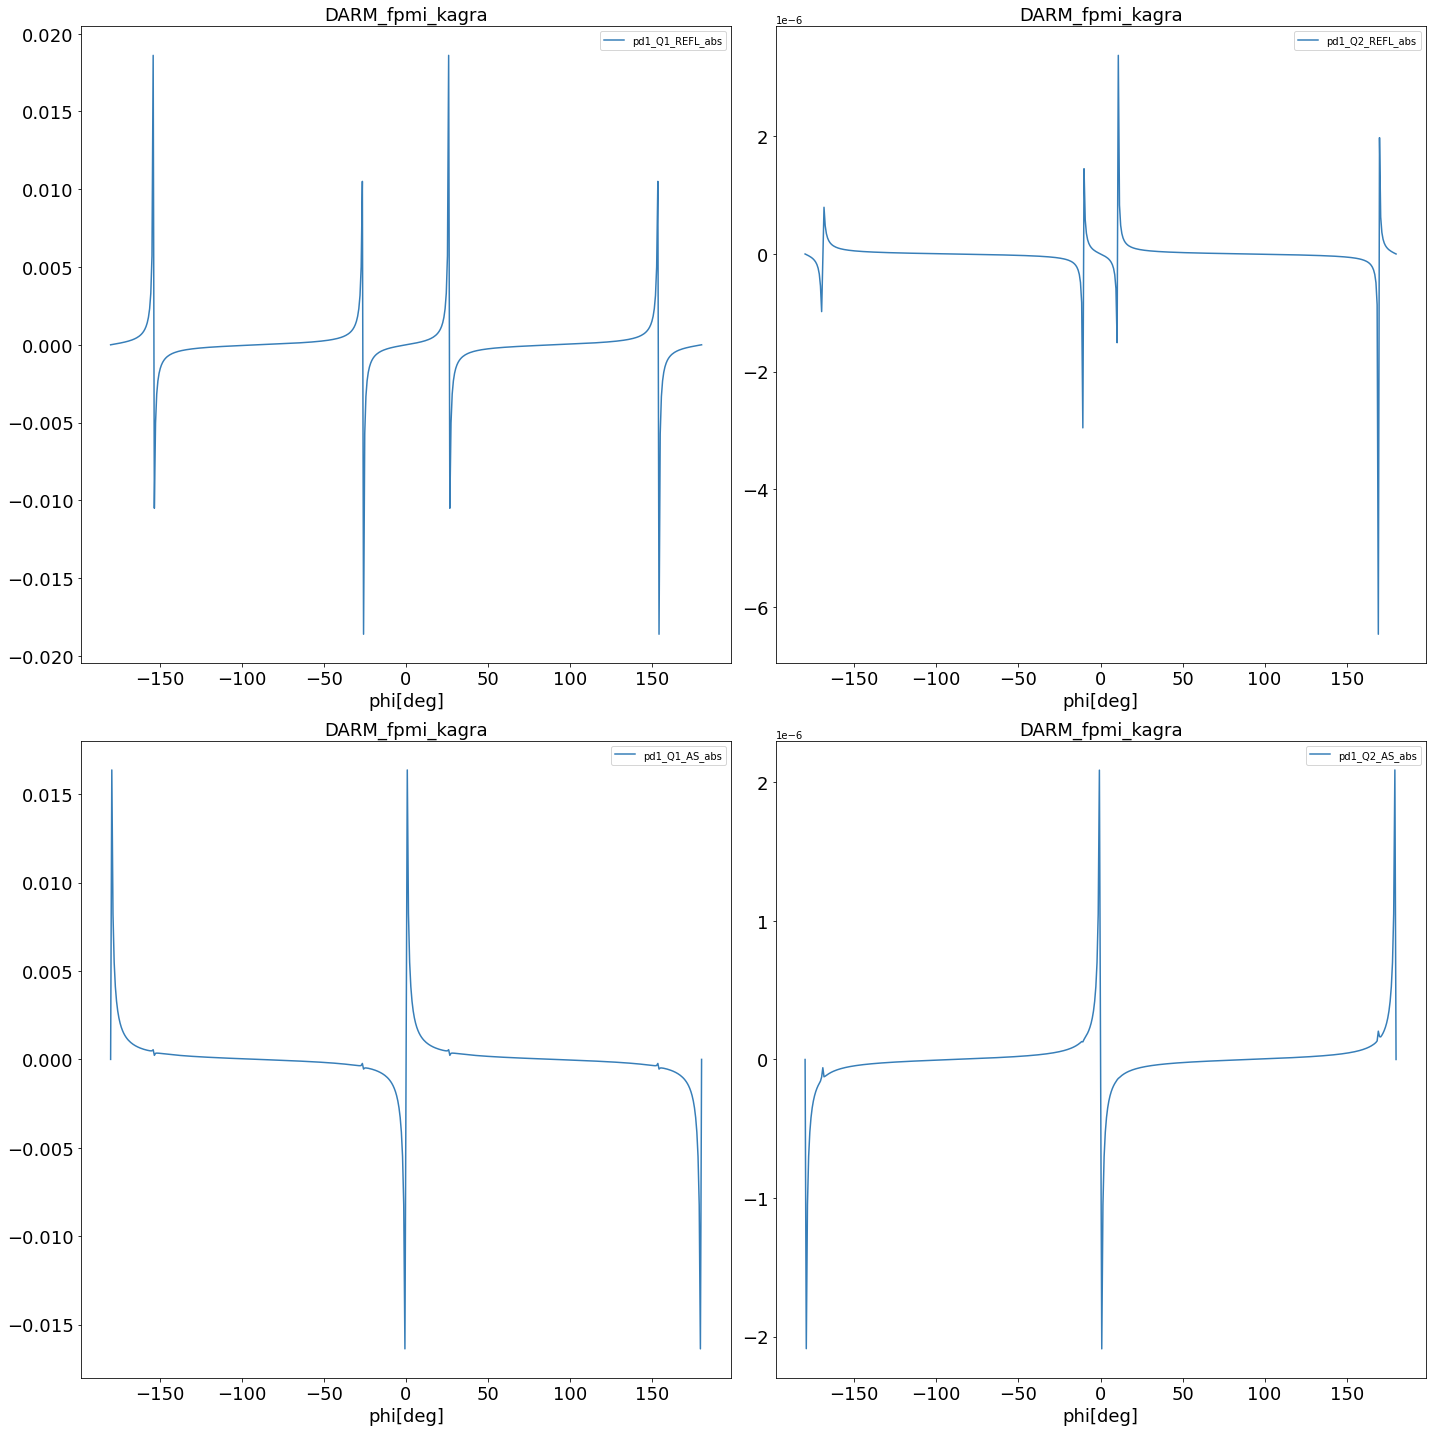

In [13]:
##################################    
#section setting pd0/pd1/pd2
##################################
inf_f_section_pd0 = [

            ]
inf_f_section_pd1 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), key='kfpmi_pd1_overplot_I1Q1'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='kfpmi_pd1_overplot_I2Q2')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='kfpmi_pd1_I1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(20, 1), key='kfpmi_pd1_Q1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='kfpmi_pd1_I2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(20, 1), key='kfpmi_pd1_Q2')],
            [sg.Text('Demodulation_frequency'),sg.Input(key='kfpmi_pd1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='kfpmi_pd1_demod_phase', default_text='0', enable_events=True)]
]
inf_f_section_pd2 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), default=True, key='kfpmi_pd2_overplot_I1Q1'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='kfpmi_pd2_plot_I_Q_overplot_f2')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='kfpmi_pd2_I1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(25, 1), key='kfpmi_pd2_Q1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='kfpmi_pd2_I2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(25, 1), key='kfpmi_pd2_Q2'),
            ],
            [sg.Text('mixer1 demodulation freq (0, 100, max)'), sg.Input(key='kfpmi_pd2_mixer1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='kfpmi_pd2_demod_phase', default_text='0', enable_events=True)]
]
inf_f_pd2_section_power = [

            ]
inf_f_sweep_section_how_simulate = [
            [sg.Radio('Power(pd0)', 'RADIO1', default=True, size=(20,1), key='kfpmi_isscan', enable_events=True),# "%s_%s"
             sg.Radio('Demod_once(pd1)','RADIO1', default=False, size=(20,1), key='kfpmi_isdemod_1', enable_events=True)],
            ### pd0_setting_section
            [collapse(inf_f_section_pd0, 'kfpmi_pd0_setting_section')],
            ### pd1_settnig_section
            [collapse(inf_f_section_pd1, 'kfpmi_pd1_setting_section')]
            ]
inf_f_transferfunction_section_how_simulate = [
    [sg.Radio('Power(pd0)', 'pd2_RADIO', default=True, size=(20,1), key='kfpmi_istransferfunction_power', enable_events=True),
    sg.Radio('Demod(pd2)','pd2_RADIO', default=False, size=(20,1), key='kfpmi_istransferfunction_demod_2', enable_events=True)],
    #
    #sg.Radio('altanative way','pd2_RADIO', default=False, size=(20,1), key='kfpmi_istransferfunction_alt', enable_events=True)
    ### pd2_setting_section
    [collapse(inf_f_pd2_section_power, 'kfpmi_pd2_section_power')],
    ### pd2_setting_section
    [collapse(inf_f_section_pd2, 'kfpmi_pd2_setting_section')]
]
###
# inf_f_ picture expand
###

##################################    
#TAB select FPMI/PRFPMI/DRFPMI
##################################
inf_p_layout =  [
                ]
inf_d_layout =  [
                ]
inf_m_layout =  [
                ]
#inf_f_tab
inf_f_layout = [
                [sg.Image('./Fabry_Perot_MI_eom_drawing.png', key='kfpmi_imageContainer', size=(400,300))],#size=(800,600)
                #[sg.Image('/Users/koyamanaoki/work/MIF/local/FPMI_pic2.png', key='kfpmi_imageContainer', size=(400,300))],#size=(800,600)
                #[sg.Button('expand', button_color=('white', 'black'), key='kfpmi_imageContainer_expand')],
                #[sg.Button('expand_s', button_color=('white', 'black'), key='kfpmi_imageContainer_expand_s')],
                ### RADIO BOX pd0/pd1/pd2
                [sg.Text('1. Select Sweep or Transfer function ')],
                [sg.Text('A new option list is displayed when you select the Sweep or Transfer function.')],# あとで消す
                [sg.Radio('Sweep', 'HOW_SIMULATE01', default=True, size=(10,1), key='kfpmi_issweep', enable_events=True),
                 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, size=(25,1), key='kfpmi_istransfunc', enable_events=True)],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(inf_f_sweep_section_how_simulate, 'kfpmi_sweep_section_how_simulate')],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(inf_f_transferfunction_section_how_simulate, 'kfpmi_transferfunction_section_how_simulate')],
                [sg.Text('2. Select which Dof to move')],
                [sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS'),default_value='DARM', size=(20, 1),key='kfpmi_dof')], #RADIOBOXに変える
                ## PDs checkbox
                [sg.Text('3. Select port (see the top figure)')],#図と関連あるとかく
                [sg.Text('check PDs')],#あとで消す
                [sg.Checkbox('REFL', size=(10, 1), default=True, key='kfpmi_REFL'),sg.Checkbox('AS', size=(5, 1),default=True, key='kfpmi_AS'),
                sg.Checkbox('nTMSY', size=(10, 1), default=True,key='kfpmi_nTMSY'),sg.Checkbox('nTMSX', size=(10, 1), default=True, key='kfpmi_nTMSX')],
                [sg.Checkbox('n2', size=(5, 1), key='kfpmi_n2'),sg.Checkbox('n3', size=(5, 1), key='kfpmi_n3'),
                sg.Checkbox('ny1', size=(7, 1), key='kfpmi_ny1'),sg.Checkbox('nx1', size=(7, 1), key='kfpmi_nx1'),
                sg.Checkbox('ny2', size=(7, 1), key='kfpmi_ny2'),sg.Checkbox('nx2', size=(7, 1), key='kfpmi_nx2'),
                sg.Checkbox('ny3', size=(7, 1), key='kfpmi_ny3'),sg.Checkbox('nx3', size=(7, 1), key='kfpmi_nx3'),
                ],
                #
                #
                [sg.Button('Plot', button_color=('white', 'black'), key='kfpmi_event')],
                ]
### EXTRA OPTION TAB
extra_option_tab =  [
                #other settings
                [sg.Text('laser_power [W]'), sg.Input(key='k_inf_c_laser_power', default_text='1')],
                ### xaxis range
                [sg.Radio('xaxis lin', 'x_plotscale', default=True, size=(10,1), key='k_inf_c_xaxis_lin', enable_events=True),
                sg.Radio('xaxis log','x_plotscale', default=False, size=(10,1), key='k_inf_c_xaxis_log', enable_events=True)],
                ### yaxis range
                [sg.Radio('yaxis lin', 'y_plotscale', default=True, size=(10,1), key='k_inf_c_yaxis_lin', enable_events=True),
                sg.Radio('yaxis log','y_plotscale', default=False, size=(10,1), key='k_inf_c_yaxis_log', enable_events=True)],
                [sg.Text('sampling num'), sg.Input(key='kfpmi_samplingnum', default_text='500', enable_events=True)],
                [sg.Text('Which data you output?')],
                [sg.Checkbox('kat file', size=(15, 1), key='k_inf_c_output_kat'), sg.Checkbox('plotdata', size=(15, 1), key='k_inf_c_output_plotdata')]
                ]
layout = [
            [sg.TabGroup([[sg.Tab('FPMI', inf_f_layout), sg.Tab('PRFPMI', inf_p_layout), sg.Tab('DRFPMI', inf_d_layout), sg.Tab('MI', inf_m_layout), sg.Tab('OPTION', extra_option_tab)]])],
            [sg.Text('xaxis range', size=(20,1), key='k_inf_c_xaxis_range_text')],
            [sg.Input(key='k_inf_c_xaxis_range_beg', default_text='-180', enable_events=True), sg.Text('to'), sg.Input(key='k_inf_c_xaxis_range_end', default_text='180', enable_events=True)]
            ] 

window = sg.Window('My window with tabs', layout, default_element_size=(12,1), finalize=True)    

type_of_pd_signal =''
#fname_output='' あとで消す
#fname_kat=''
check = False
#default
type_of_pd_signal = 'sweep_power'
#
#
#
while True:    
    if(check==False):
        window['kfpmi_sweep_section_how_simulate'].update(visible=True)
        window['kfpmi_transferfunction_section_how_simulate'].update(visible=False)
        window['kfpmi_pd0_setting_section'].update(visible=True)
        window['kfpmi_pd1_setting_section'].update(visible=False)
        window['kfpmi_pd2_section_power'].update(visible=False)
        window['kfpmi_pd2_setting_section'].update(visible=False)
        check = True
    event, values = window.read()

    #print(event,values)
    if event == sg.WIN_CLOSED:
        break
    if event == 'kfpmi_Exit':
        break        
    if event == 'kfpmi_imageContainer_expand':
        window['kfpmi_imageContainer'].update('/Users/koyamanaoki/work/MIF/local/FPMI_pic.png')
    if event == 'kfpmi_imageContainer_expand_s':
        #window['kfpmi_imageContainer'].update(data=convert_to_bytes('/Users/koyamanaoki/work/MIF/local/FPMI_pic.png', resize=(800, 600)))
        window['kfpmi_imageContainer'].update(size=(760, 500))
    if event == 'k_inf_c_xaxis_range_beg' and values['k_inf_c_xaxis_range_beg'] and values['k_inf_c_xaxis_range_beg'][-1] not in ('0123456789.-'):
        window['k_inf_c_xaxis_range_beg'].update(values['k_inf_c_xaxis_range_beg'][:-1])
    if event == 'k_inf_c_xaxis_range_end' and values['k_inf_c_xaxis_range_end'] and values['k_inf_c_xaxis_range_end'][-1] not in ('0123456789.-'):
        window['k_inf_c_xaxis_range_end'].update(values['k_inf_c_xaxis_range_end'][:-1])
    ### update xaxis default value
    if event == 'k_inf_c_xaxis_lin':
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    if event == 'k_inf_c_xaxis_log':
        default_xaxis_beg = '0.01'
        default_xaxis_end = '1000'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    ### visible/invisible advanced setting
    #
    # この辺を関数にできそう。Trueにして欲しいウィンドウの名前を渡してそれ以外全部Falseにするとか
    # window, keylist, Trueにするkeylist 引数
    # 一番長い
    if event == 'kfpmi_issweep':
        window['kfpmi_sweep_section_how_simulate'].update(visible=True)
        window['kfpmi_transferfunction_section_how_simulate'].update(visible=False)
        window['kfpmi_pd0_setting_section'].update(visible=True)
        window['kfpmi_pd1_setting_section'].update(visible=False)
        window['kfpmi_pd2_section_power'].update(visible=False)
        window['kfpmi_pd2_setting_section'].update(visible=False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
        #default value
        type_of_pd_signal = 'sweep_power'
    if event == 'kfpmi_istransfunc':
        window['kfpmi_sweep_section_how_simulate'].update(visible=False)
        window['kfpmi_transferfunction_section_how_simulate'].update(visible=True)
        window['kfpmi_pd0_setting_section'].update(visible=False)
        window['kfpmi_pd1_setting_section'].update(visible=False)
        window['kfpmi_pd2_section_power'].update(visible=True)
        window['kfpmi_pd2_setting_section'].update(visible=False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
        #default value
        type_of_pd_signal = 'transferfunction_power'
    if event == 'k_inf_isscan':
        window['kfpmi_pd0_setting_section'].update(visible=True)
        window['kfpmi_pd1_setting_section'].update(visible=False)
        window['kfpmi_pd2_section_power'].update(visible=False)
        window['kfpmi_pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'sweep_power'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        values['k_inf_c_xaxis_lin'] = True
        values['k_inf_c_xaxis_log'] = False
        window['k_inf_c_xaxis_lin'].update(True)
        window['k_inf_c_xaxis_log'].update(False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    if event == 'kfpmi_isdemod_1':
        window['kfpmi_pd0_setting_section'].update(visible=False)
        window['kfpmi_pd1_setting_section'].update(visible=True)
        window['kfpmi_pd2_section_power'].update(visible=False)
        window['kfpmi_pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'sweep_demod_1'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        values['k_inf_c_xaxis_lin'] = True
        values['k_inf_c_xaxis_log'] = False
        window['k_inf_c_xaxis_lin'].update(True)
        window['k_inf_c_xaxis_log'].update(False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    if event == 'kfpmi_istransferfunction_power':
        window['kfpmi_pd0_setting_section'].update(visible=False)
        window['kfpmi_pd1_setting_section'].update(visible=False)
        window['kfpmi_pd2_section_power'].update(visible=True)
        window['kfpmi_pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'transferfunction_power'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        values['k_inf_c_xaxis_lin'] = True
        values['k_inf_c_xaxis_log'] = False
        window['k_inf_c_xaxis_lin'].update(True)
        window['k_inf_c_xaxis_log'].update(False)
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
    if event == 'kfpmi_istransferfunction_demod_2':
        window['kfpmi_pd0_setting_section'].update(visible=False)
        window['kfpmi_pd1_setting_section'].update(visible=False)
        window['kfpmi_pd2_section_power'].update(visible=False)
        window['kfpmi_pd2_setting_section'].update(visible=True)
        type_of_pd_signal = 'transferfunction_demod_2'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis f[Hz] range')
        values['k_inf_c_xaxis_lin'] = False
        values['k_inf_c_xaxis_log'] = True
        window['k_inf_c_xaxis_lin'].update(False)
        window['k_inf_c_xaxis_log'].update(True)
        default_xaxis_beg = '0.01'
        default_xaxis_end = '1000'
        window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
        window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
        '''
        if event == 'kfpmi_istransferfunction_alt':
            window['kfpmi_pd0_setting_section'].update(visible=False)
            window['kfpmi_pd1_setting_section'].update(visible=False)
            window['kfpmi_pd2_section_power'].update(visible=False)
            window['kfpmi_pd2_setting_section'].update(visible=True)
            type_of_pd_signal = 'transferfunction_alt'
            ## default xrange value ##
            window['k_inf_c_xaxis_range_text'].update('xaxis f[Hz] range')
            values['k_inf_c_xaxis_lin'] = False
            values['k_inf_c_xaxis_log'] = True
            window['k_inf_c_xaxis_lin'].update(False)
            window['k_inf_c_xaxis_log'].update(True)
            default_xaxis_beg = '0.01'
            default_xaxis_end = '1000'
            window['k_inf_c_xaxis_range_beg'].update(default_xaxis_beg)
            window['k_inf_c_xaxis_range_end'].update(default_xaxis_end)
        '''        

    #
    # (2020/09/02)この下がタブ全部で共通にできると短くなる
    #

    if event == 'kfpmi_event':           # FPMI
        interferometer_config = "fpmi"

        l_port_true, l_port_true_name, l_pd_true, l_pd_true_name = make_common_config(values, type_of_pd_signal)

        ###############################
        ### get variables from GUI ###
        ###############################

        ### PD location ###
        """
        dic_inf_f_ispds = {
            ### PDs
            #'REFL':values['%s_REFL' % interferometer],
            'REFL':values['kfpmi_REFL'],#bool #REFL
            'AS':values['kfpmi_AS'],#bool #AS
            'nTMSY':values['kfpmi_nTMSY'],#bool
            'nTMSX':values['kfpmi_nTMSX'],#bool
            'n2':values['kfpmi_n2'],#bool
            'n3':values['kfpmi_n3'],#bool
            'ny1':values['kfpmi_ny1'],#bool
            'nx1':values['kfpmi_nx1'],#bool
            'ny2':values['kfpmi_ny2'],#bool
            'nx2':values['kfpmi_nx2'],#bool
            'ny3':values['kfpmi_ny3'],#bool
            'nx3':values['kfpmi_nx3'],#bool
            }
        """
        #########
        #
        # plot variables
        # 
        xaxis_range_beg = values['k_inf_c_xaxis_range_beg']
        xaxis_range_end = values['k_inf_c_xaxis_range_end']
        #yaxis_range_beg = values['yaxis_range_beg']
        #yaxis_range_end = values['yaxis_range_end']

        if(values['k_inf_c_xaxis_log'] == True):
            x_plotscale = 'log'
        else:
            x_plotscale = 'linear'
        if(values['k_inf_c_yaxis_log'] == True):
            y_plotscale = 'log'
        else:
            y_plotscale = 'linear'   
        #########
        dic_inf_f_advanced_setting = {
            ### DoF
            'dof':values['kfpmi_dof'],#str
            ### pd0/pd1/pd2?
            
            'type_of_pd_signal':type_of_pd_signal,#str
            ### advanced setting
            'laser_power':values['k_inf_c_laser_power'],#str
            #
            # plot variables
            # 
            'x_plotscale':x_plotscale,#str
            'xaxis_range_beg':values['k_inf_c_xaxis_range_beg'],#str
            'xaxis_range_end':values['k_inf_c_xaxis_range_end'],#str
            'y_plotscale':y_plotscale,#str
            #'yaxis_range_beg':values['k_inf_c_yaxis_range_beg'],#str
            #'yaxis_range_end':values['k_inf_c_yaxis_range_end'],#str
            'pd1_demod_phase':values['kfpmi_pd1_demod_phase'],#str
            'pd1_demodfreq':values['kfpmi_pd1_demodfreq'],#str
            'pd2_demod_phase':values['kfpmi_pd2_demod_phase'],#str
            'pd2_mixer1_demodfreq':values['kfpmi_pd2_mixer1_demodfreq'],#str
            'samplingnum':values['kfpmi_samplingnum'],#str
            'l_port_true_name':l_port_true_name,
            'l_port_true':l_port_true
            }
        
        kat = finesse.kat()
        code = generate_kat_FPMI(l_pd_true_name, l_pd_true, dic_inf_f_advanced_setting)
        kat.parse(code)
        out = kat.run()
        plot_title = '%s_%s_kagra' % (values['kfpmi_dof'], interferometer_config)

        #
        # 下のやつ3つ共通にできるか考える
        #

        ### scan
        if(type_of_pd_signal == 'sweep_power' or type_of_pd_signal == 'transferfunction_power'):
            fig1 = plt.figure(figsize=(20,20))
            # plt.xscale(x_plotscale)
            # plt.yscale(y_plotscale)
            # ここでも結果表示できるか調べる
            fig1.suptitle('abs')
            plotnum = 0
            
            for port in l_port_true:
                plotnum += 1 #plotnum
            vh_plotnum = math.ceil(math.sqrt(plotnum))
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                for port in l_port_true:
                    plt.subplot(vh_plotnum,vh_plotnum,i+1) #Axes
                    plt.plot(out.x, out['pd0_%s' % port], label='power_%s' % port, color = '#377eb8')
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.ylabel('abs')
                    ## change title to configuration name
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend()
                    i += 1
            plt.tight_layout()
        ### demod once (pd1)
        if(type_of_pd_signal=='sweep_demod_1'):
            # 
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle('absolute value')
            plotnum = 0
            for port in l_port_true:
                plotnum += 1 #plotnum
            if(plotnum > 0):
                i = 0
                inf_f_list_demon_phase = ['kfpmi_pd1_I1', 'kfpmi_pd1_Q1', 
                                            'kfpmi_pd1_overplot_I1Q1', 
                                            'kfpmi_pd1_I2', 'kfpmi_pd1_Q2', 
                                            'kfpmi_pd1_overplot_I2Q2']
                inf_f_list_demon_phase_name = ['pd1_I1', 'pd1_Q1', 
                                                'pd1_plot_I_Q_overplot_f1', 
                                                'pd1_I2', 'pd1_Q2', 
                                                'pd1_plot_I_Q_overplot_f2']
                inf_f_list_demon_phase_True = [k for k in inf_f_list_demon_phase if values[k] == True]
                j = len(inf_f_list_demon_phase_True)
                print('j'+str(j))
                if(j==0):
                    values['kfpmi_pd1_I1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = plotnum
                for port in l_port_true:
                    k = 1
                    for l in range(len(inf_f_list_demon_phase)):
                        if (values[inf_f_list_demon_phase[l]]==True):
                            # abs
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            if(inf_f_list_demon_phase[l]=='kfpmi_pd1_overplot_I1Q1'):
                                plt.plot(out.x, out['pd1_I1_%s' % (port)], label='pd1_I1__%s_abs' % (port), color = '#377eb8')
                                plt.plot(out.x, out['pd1_Q1_%s' % (port)], label='pd1_Q1__%s_abs' % (port), color = '#4daf4a')
                            elif(inf_f_list_demon_phase[l]=='kfpmi_pd1_overplot_I2Q2'):
                                plt.plot(out.x, out['pd1_I2_%s' % (port)], label='pd1_I2__%s_abs' % (port), color = '#377eb8')
                                plt.plot(out.x, out['pd1_Q2_%s' % (port)], label='pd1_Q2__%s_abs' % (port), color = '#4daf4a')
                            else:
                                plt.plot(out.x, out['%s_%s' % (inf_f_list_demon_phase_name[l], port)], label='%s_%s_abs' % (inf_f_list_demon_phase_name[l], port), color = '#377eb8')
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                    i += j
            plt.tight_layout()
        ## demod phase tuning
        '''
        if (type_of_pd_signal=='transferfunction_alt'):
            fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
            for pp in np.linspace(0,180,7):
                PRCL_sweep.REFLI1.phase1 = pp
                PRCL_sweep.REFLQ1.phase1 = pp+90
                PRCL = PRCL_sweep.run()
                ax1.plot(PRCL.x, PRCL["REFLI1"],label=pp)
                ax2.plot(PRCL.x, PRCL["REFLQ1"],label=pp)
            plt.legend(loc=1)
        '''
        ### Transfer function(pd2)
        if(type_of_pd_signal=='transferfunction_demod_2'):
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle('abs')
            plotnum = 0
            for port in l_port_true:
                plotnum += 1 #plotnum
            if(plotnum > 0):
                i = 0
                inf_f_list_demon_phase = ['kfpmi_pd2_I1', 'kfpmi_pd2_Q1', 
                                            'kfpmi_pd2_overplot_I1Q1', 
                                            'kfpmi_pd2_I2', 'kfpmi_pd2_Q2', 
                                            'kfpmi_pd2_plot_I_Q_overplot_f2'
                                            ]
                inf_f_list_demon_phase_name = ['pd2_I1', 'pd2_Q1', 
                                            'pd2_plot_I_Q_overplot_f1', 
                                            'pd2_I2', 'pd2_Q2', 
                                            'pd2_plot_I_Q_overplot_f2']
                inf_f_list_demon_phase_True = [k for k in inf_f_list_demon_phase if values[k] == True]
                j = len(inf_f_list_demon_phase_True)
                print('j'+str(j))
                if(j==0):
                    values['kfpmi_pd2_I1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = 2*plotnum
                for port in l_port_true:
                    k = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                    for l in range(len(inf_f_list_demon_phase)):
                        if (values[inf_f_list_demon_phase[l]]==True):
                            # abs
                            plt.subplot(v_plotnum,h_plotnum,k) #Axes

                            if(inf_f_list_demon_phase[l]=='kfpmi_pd2_overplot_I1Q1'):
                                plt.plot(out.x, out['pd2_I1_%s' % (port)], label='pd2_I1__%s_abs' % (port), color = '#377eb8')
                                plt.plot(out.x, out['pd2_Q1_%s' % (port)], label='pd2_Q1__%s_abs' % (port), color = '#4daf4a')
                            elif(inf_f_list_demon_phase[l]=='kfpmi_pd2_plot_I_Q_overplot_f2'):
                                plt.plot(out.x, out['pd2_I2_%s' % (port)], label='pd2_I2__%s_abs' % (port), color = '#377eb8')
                                plt.plot(out.x, out['pd2_Q2_%s' % (port)], label='pd2_Q2__%s_abs' % (port), color = '#4daf4a')
                            else:
                                plt.plot(out.x, out['%s_%s' % (inf_f_list_demon_phase_name[l], port)], label='%s_%s_abs' % (inf_f_list_demon_phase_name[l], port), color = '#377eb8')
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()

                            # phase
                            plt.subplot(v_plotnum,h_plotnum,k+h_plotnum) #Axes
                            if(inf_f_list_demon_phase[l]=='kfpmi_pd2_overplot_I1Q1'):
                                plt.plot(out.x, np.angle(out['pd2_I1_%s' % (port)]), label='pd2_I1__%s_phase' % (port), color = '#377eb8')
                                plt.plot(out.x, np.angle(out['pd2_Q1_%s' % (port)]), label='pd2_Q1__%s_phase' % (port), color = '#4daf4a')
                            elif(inf_f_list_demon_phase[l]=='kfpmi_pd2_plot_I_Q_overplot_f2'):
                                plt.plot(out.x, np.angle(out['pd2_I2_%s' % (port)]), label='pd2_I2__%s_phase' % (port), color = '#377eb8')
                                plt.plot(out.x, np.angle(out['pd2_Q2_%s' % (port)]), label='pd2_Q2__%s_phase' % (port), color = '#4daf4a')
                            else:
                                plt.plot(out.x, np.angle(out['%s_%s' % (inf_f_list_demon_phase_name[l], port)]), label='%s_%s_phase' % (inf_f_list_demon_phase_name[l], port), color = 'firebrick')
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                    i += j
            plt.tight_layout()
        
        plt.show()
        
        if values['k_inf_c_output_kat'] == True:
            kat=code
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(('ALL Files', '*.kat'),))

            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok('Error : there is a file %s' % fname_kat)
            except Exception:
                sg.popup_ok('Unexpected error:', sys.exc_info()[0])

        if values['k_inf_c_output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            try:
                f = open(fname_plotdata, 'x')
                import datetime
                dt_now = datetime.datetime.now()
                header_file = "# This is finesse result simulated at %s \n# x " % dt_now
                arr = np.empty((0, out.x.size), float)
                arr = np.append(arr, [out.x], axis=0)
                for port in dic_inf_f_ispds.ports():
                      if dic_inf_f_ispds[port]==True:
                        arr = np.append(arr, [out["pd0_%s" % port]], axis=0)
                        header_file += "pd0_%s " % port
                L = np.asarray(arr).T
                x=L.tolist()
                plotdata=[" ".join(map(str, i)) for i in x]
                #print(plotdata)
                f.writelines(header_file + '\n')
                for i in plotdata:
                    f.writelines(i)
                    f.write('\n')
                f.close()            
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])

window.close()         

In [ ]:
#l_gui_port = ["FPMI_REFL", "FPMI_AS", "FPMI_TMSX", "FPMI_TMSY"]


# pdの名前_list
# type_of_pd_signal